![Alt text](./figures/logo.png)

source: @allison_horst https://github.com/allisonhorst/penguins

You have been asked to support a team of researchers who have been collecting data about penguins in Antartica! The data is available in csv-Format as `penguins.csv`

**Origin of this data** : Data were collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network.

**The dataset consists of 5 columns.**

Column | Description
--- | ---
culmen_length_mm | culmen length (mm)
culmen_depth_mm | culmen depth (mm)
flipper_length_mm | flipper length (mm)
body_mass_g | body mass (g)
sex | penguin sex

Unfortunately, they have not been able to record the species of penguin, but they know that there are **at least three** species that are native to the region: **Adelie**, **Chinstrap**, and **Gentoo**.  Your task is to apply your data science skills to help them identify groups in the dataset!

In [44]:
# Import Required Packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import seaborn as sns
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")


## Reading the CSV file

First lets read the CSV file.

In [2]:
# Loading and examining the dataset
penguins_df = pd.read_csv("./data/penguins.csv")
penguins_df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,36.7,19.3,193.0,3450.0,FEMALE
4,39.3,20.6,190.0,3650.0,MALE


## Cleaning Data

The uploaded dataset will be assessed to evaluate its quality and ensure it is suitable for analysis. This includes checking for missing values, identifying outliers, and verifying data types and consistency.


In [3]:
df = penguins_df  # Assign a shorter, more convenient variable name for easier handling

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   332 non-null    float64
 1   culmen_depth_mm    332 non-null    float64
 2   flipper_length_mm  332 non-null    float64
 3   body_mass_g        332 non-null    float64
 4   sex                332 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.1+ KB


In [5]:
df['sex'].unique()

array(['MALE', 'FEMALE'], dtype=object)

In [6]:
df['sex']=df['sex'].astype('category')

In [7]:
df.describe(include='category')

,sex
count,332
unique,2
top,MALE
freq,167


In [8]:
df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,332.000000,332.000000,332.000000,332.000000
mean,44.021084,17.153012,200.975904,4206.475904
std,5.452462,1.960275,14.035971,806.361278
min,32.100000,13.100000,172.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.700000,17.300000,197.000000,4025.000000
75%,48.625000,18.700000,213.000000,4781.250000
max,59.600000,21.500000,231.000000,6300.000000


- Created a shorter alias `'df'` for the original DataFrame `'penguins_df'` to simplify references.
- Ensured that only non-empty (non-null) rows are considered.
- The `'sex'` column contains only two unique categories: `'MALE'` and `'FEMALE'`.
- Converted the data type of the `'sex'` column to `'category'` for optimised storage and performance.
- No outliers were identified.


## Preliminary Analysis

To begin the exploratory analysis, a pair plot was generated to visualise the relationships between numerical features in the dataset.

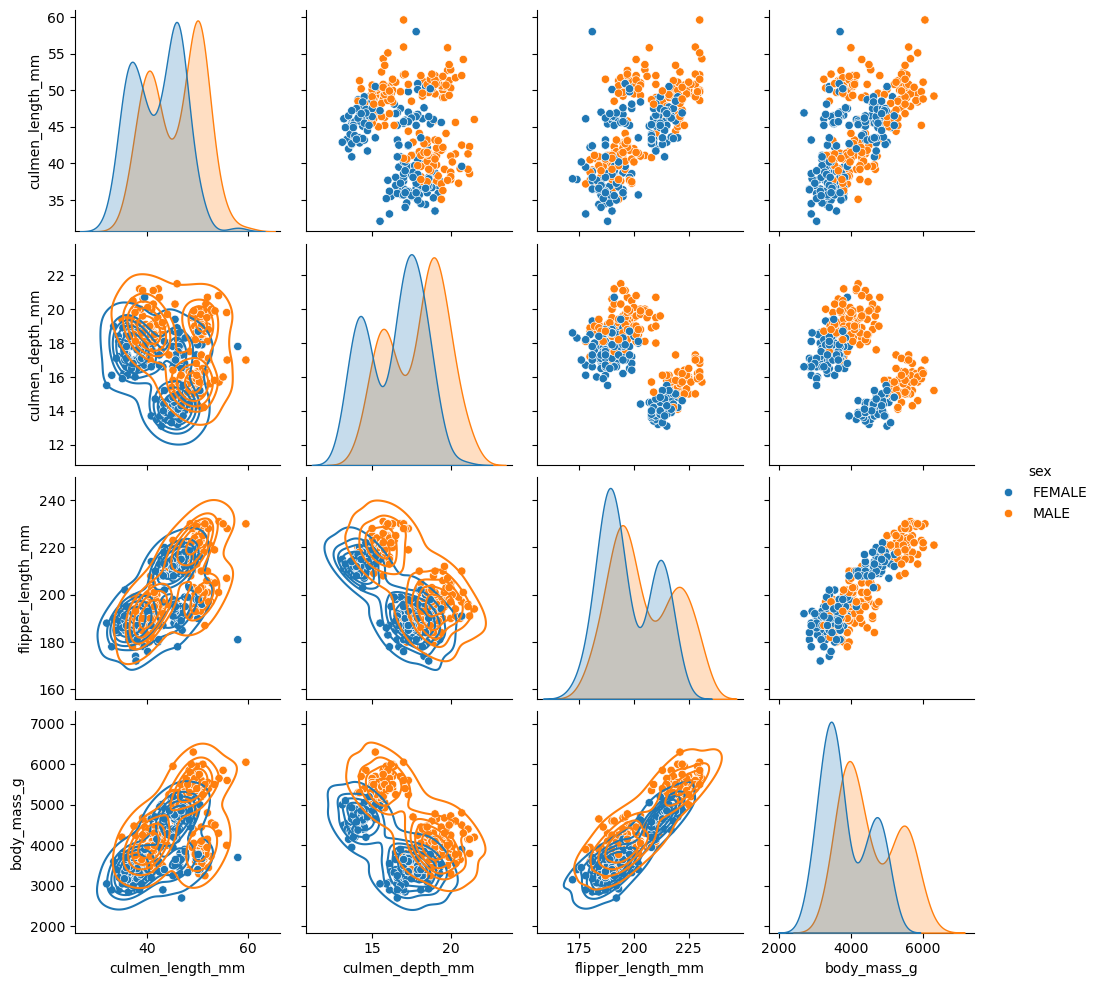

In [12]:
g = sns.pairplot(df, hue='sex')
g.map_lower(sns.kdeplot, levels=6, color="green")
plt.savefig('./plots/pairplot.png')
plt.show()

### Initial Insights

- The data can be categorised into two groups — `'MALE'` and `'FEMALE'` — and has been colour-coded accordingly in the plot.
- Preliminary observations indicate that **male** individuals tend to have **larger body dimensions and greater weight**.
- The pair plot also reveals visual groupings, suggesting the presence of three distinct clusters within the data — a promising sign for uncovering the underlying species.
- The distributions of the four numerical features appear to be **bimodal**. While this might initially suggest the presence of only two species, the clustering into three distinct groups supports the hypothesis of three separate species.


## Clustering

### Dummy Variables

To prepare the data for clustering, the `'sex'` column is first transformed into a binary variable. A new column, `'is_male'`, is added to the dataset, containing a value of `1.0` if the original `'sex'` entry is `'MALE'`, and `0.0` otherwise. This transformation ensures that the categorical variable is represented numerically and is compatible with `'scikit-learn'` learning algorithms.

In [50]:
df['is_male'] = pd.get_dummies(df['sex'],drop_first=True, dtype='float')

df_xy = df[df['is_male']==1.0]
df_xx = df[df['is_male']==0.0]
df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,is_male
0,39.1,18.7,181.0,3750.0,MALE,1.0
1,39.5,17.4,186.0,3800.0,FEMALE,0.0
2,40.3,18.0,195.0,3250.0,FEMALE,0.0
3,36.7,19.3,193.0,3450.0,FEMALE,0.0
4,39.3,20.6,190.0,3650.0,MALE,1.0


### Elbow Analysis for Optimal Clusters

To evaluate the optimal number of clusters, the dataset was divided into two subsets based on sex: one for male individuals (`df_xy`) and another for females (`df_xx`). This was done under the assumption that the `'sex'` feature might introduce noise or obscure patterns relevant to clustering.

In this step, the male subset is used to determine the most appropriate number of clusters using the elbow method. A loop is used to iterate through different values of `k` (the number of clusters), and for each `k`, a pipeline is created that combines standardisation and clustering.

The numerical features are first standardised using `StandardScaler` to ensure that all features contribute equally to the distance calculations. Then, `KMeans` clustering is applied to group similar observations.

The inertia (a measure of how internally coherent clusters are) is recorded for each value of `k`. These values are then plotted to visualise the “elbow” — a point where increasing the number of clusters yields diminishing returns in terms of improved fit.

This approach ensures a structured and consistent method for identifying the most meaningful number of clusters within both male and female subsets.

First the analysis will be done with the male subset.

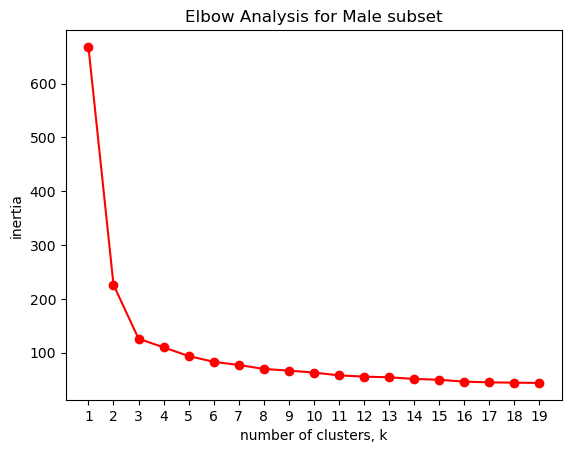

In [57]:
samples=df_xy.drop('sex',axis=1)
ks = range(1, 20)
inertias = []

for k in ks:
    scaler = StandardScaler()
    kmeans = KMeans(n_clusters=k, random_state=69)
    pipeline = make_pipeline(scaler,kmeans)
    
    # Fit model to samples
    pipeline.fit(samples)
    
    # Append the inertia to the list of inertias
    inertias.append(kmeans.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o', color='red')
plt.title('Elbow Analysis for Male subset')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.savefig('./plots/elbow_test_xy.png')
plt.show()

Following the same approach, the analysis is now repeated using the female subset (`df_xx`). By evaluating the clustering structure separately for female individuals, we can assess whether the optimal number of clusters differs from that of the male subset, and ensure that any patterns specific to this group are properly captured.

The same pipeline is applied — standardising the numerical features using `StandardScaler`, and performing clustering with `KMeans` across a range of cluster values. Inertia values are recorded and plotted to identify the elbow point for the female subset.


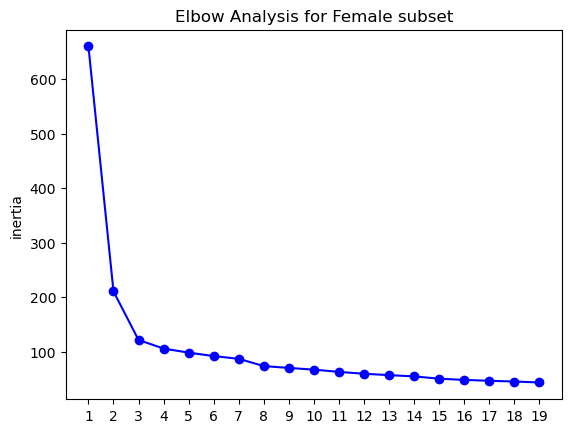

In [58]:
samples=df_xx.drop('sex',axis=1)
ks = range(1, 20)
inertias = []

for k in ks:
    scaler = StandardScaler()
    kmeans = KMeans(n_clusters=k, random_state=69)
    pipeline = make_pipeline(scaler,kmeans)
    
    # Fit model to samples
    pipeline.fit(samples)
    
    # Append the inertia to the list of inertias
    inertias.append(kmeans.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o', color='blue')
plt.title('Elbow Analysis for Female subset')
plt.ylabel('inertia')
plt.xticks(ks)
plt.savefig('./plots/elbow_test_xx.png')
plt.show()

Based on the elbow plots generated for both the male and female subsets, the optimal number of clusters appears to be **three** in each case. In both plots, a noticeable "elbow" occurs at `k = 3`, where the reduction in inertia begins to level off. This suggests that adding more clusters beyond this point yields minimal improvement in cluster compactness.

This supports the hypothesis that the dataset may contain three distinct natural groupings, which aligns with the context of the problem — identifying three underlying penguin species. With this insight, further analysis can now proceed using `k = 3` for clustering.


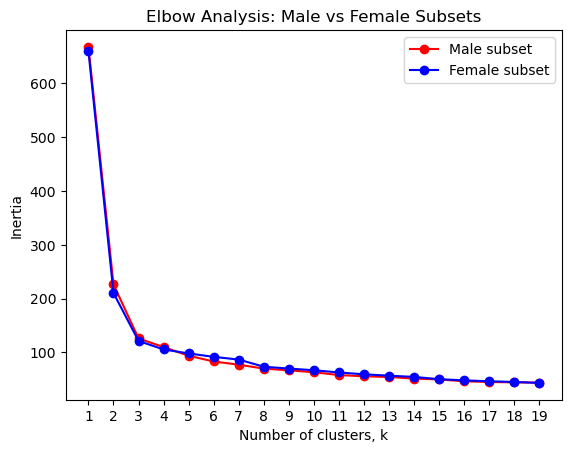

In [59]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

ks = range(1, 20)

# Inertia lists for each subset
inertias_xy = []  # Male
inertias_xx = []  # Female

# Male subset
samples_xy = df_xy.drop('sex', axis=1)
for k in ks:
    pipeline = make_pipeline(StandardScaler(), KMeans(n_clusters=k, random_state=69))
    pipeline.fit(samples_xy)
    inertias_xy.append(pipeline.named_steps['kmeans'].inertia_)

# Female subset
samples_xx = df_xx.drop('sex', axis=1)
for k in ks:
    pipeline = make_pipeline(StandardScaler(), KMeans(n_clusters=k, random_state=69))
    pipeline.fit(samples_xx)
    inertias_xx.append(pipeline.named_steps['kmeans'].inertia_)

# Plot both curves on the same graph
plt.plot(ks, inertias_xy, '-o', label='Male subset', color='red')
plt.plot(ks, inertias_xx, '-o', label='Female subset', color='blue')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.title('Elbow Analysis: Male vs Female Subsets')
plt.xticks(ks)
plt.legend()
plt.savefig('./plots/elbow_comparison.png')
plt.show()


In [ ]:
scaler = StandardScaler()
kmeans = KMeans(n_clusters=3, random_state=69)
pipeline = make_pipeline(scaler,kmeans)

samples_xy=df_xy.iloc[:,0:4]
samples_xx=df_xx.iloc[:,0:4]
pipeline.fit_transform(sample_xy)
